In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/done/ml_data.csv', encoding='cp949')

In [3]:
ori_y = data['단위생산량']
data['단위생산량'] = np.log1p(data['단위생산량'])
# 추후 결괏값을 expm1()으로 환원하여 실제 생산량으로!

In [4]:
random_state = 0

In [5]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [6]:
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X, y)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(f'{model.__class__.__name__} 5 CV 시 최적 평균 RMSE 값: {np.round(rmse, 4)}, 최적 alpha:{grid_model.best_params_}')
    return grid_model.best_estimator_

In [7]:
def get_rmse(model):
    from sklearn.metrics import mean_squared_error
    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    # rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [8]:
y = data['단위생산량']
X = data.drop(columns='단위생산량')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# XGBoost

In [9]:
# xgb_reg = XGBRegressor()
# xgb_reg.fit(X_train, y_train)

# get_rmse(xgb_reg)

In [10]:
# 시간이 걸림
# xgb_params = {'n_estimators':[40, 80, 120, 160, 200],
#               'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#               'colsample_bytree': [0.0001, 0.0005, 0.001, 0.002, 0.005],
#               'subsample': [0.01, 0.05, 0.1, 0.2, 0.5]
#                  }
# best_xgb = print_best_params(xgb_reg, xgb_params)

In [11]:
# XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.2901, 최적 alpha:{'n_estimators': 100}
# XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.289, 최적 alpha:{'n_estimators': 500}
# XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.2875, 최적 alpha:{'n_estimators': 120}
# XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.289, 최적 alpha:{'learning_rate': 0.01}
# XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.2652, 최적 alpha:{'colsample_bytree': 0.001}
# XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.2652, 최적 alpha:{'colsample_bytree': 0.0001}
# XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.2581, 최적 alpha:{'subsample': 0.75}
# XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.2523, 최적 alpha:{'subsample': 0.1}

In [12]:
# xgb_reg = XGBRegressor(n_estimators=270, learning_rate=0.0466, colsample_bytree=0.075, subsample=0.052)
# xgb_reg.fit(X_train, y_train)

# get_rmse(xgb_reg)

In [13]:
# 원본 XGBRegressor 로그 변환된 RMSE: 0.273
# 튜닝 XGBRegressor 로그 변환된 RMSE: 0.251 (n_estimators=120, learning_rate=0.05, colsample_bytree=0.001, subsample=0.1)
# 최적 XGBRegressor 로그 변환된 RMSE: 0.264 (n_estimators=80, learning_rate=0.1, colsample_bytree=0.00001, subsample=0.05)

## XGBoost HyperOpt 하이퍼 파라미터 튜닝

In [14]:
from hyperopt import hp
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_state)

In [16]:
search_space = {
    'max_depth': scope.int(hp.quniform("max_depth", 1, 5, 1)),
    'gamma': hp.uniform ('gamma', 0, 1),
    'reg_alpha' : hp.uniform('reg_alpha', 0, 10),
    'reg_lambda' : hp.uniform('reg_lambda', 10, 100),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
    'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
    'n_estimators': 10000,
    'random_state':random_state,
    'learning_rate': hp.uniform('learning_rate', 0, .15),
    'max_bin' : scope.int(hp.quniform('max_bin', 200, 550, 1))}

In [17]:
def objective_func(search_space):
    xgb_reg = XGBRegressor(**search_space)
    
    evaluation = [(X_tr, y_tr), (X_val, y_val)]
    xgb_reg.fit(X_tr, y_tr, eval_set=evaluation, eval_metric="rmse",
              early_stopping_rounds=100, verbose=False)
    
    pred = xgb_reg.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    
    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}

In [18]:
trial_val = Trials()
best = fmin(fn=objective_func,
            space=search_space,
            algo=tpe.suggest, max_evals=400, trials=trial_val)
print('best:', best)

100%|██████████████████████████████████████████████| 400/400 [02:28<00:00,  2.69trial/s, best loss: 0.1843641162583066]
best: {'colsample_bytree': 0.6054859101525554, 'gamma': 0.025440070294753123, 'learning_rate': 0.08407767154741161, 'max_bin': 392.0, 'max_depth': 4.0, 'min_child_weight': 2.713299888157886, 'reg_alpha': 3.9942541143838053, 'reg_lambda': 33.64549337123532}


In [19]:
xgb_standard = XGBRegressor().fit(X_train, y_train)
standard_score = mean_squared_error(y_test, xgb_standard.predict(X_test), squared=False)

print('XGBRegressor 로그 변환된 RMSE_Standard_Model:', np.round(standard_score, 4))

best_xgb_model = trial_val.results[np.argmin([r['loss'] for r in trial_val.results])]['model']

xgb_preds_best = best_xgb_model.predict(X_test)
xgb_score_best = mean_squared_error(y_test, xgb_preds_best, squared=False)
print('XGBRegressor 로그 변환된 RMSE_Best_Model:', np.round(xgb_score_best, 4))

XGBRegressor 로그 변환된 RMSE_Standard_Model: 0.188
XGBRegressor 로그 변환된 RMSE_Best_Model: 0.1844


<AxesSubplot:>

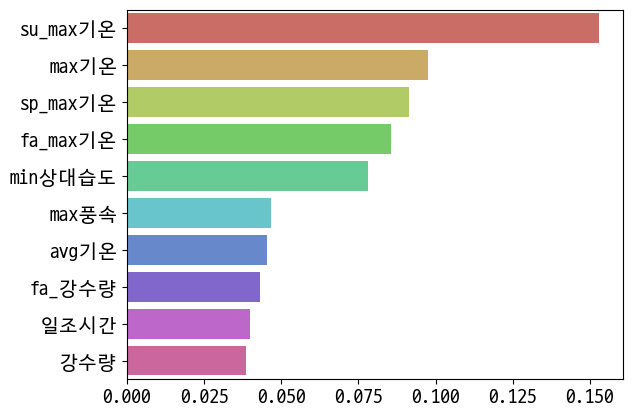

In [20]:
fi_value = best_xgb_model.feature_importances_
fi = pd.Series(fi_value, X.columns)
fi_top10 = fi.sort_values(ascending=False)[:10]

sns.barplot(x=fi_top10.values, y=fi_top10.index, palette='hls')

# LightGBM

In [21]:
from lightgbm import LGBMRegressor

In [22]:
# lgbm_reg = LGBMRegressor()
# lgbm_reg.fit(X_train, y_train)

# get_rmse(lgbm_reg)

In [23]:
# lgbm_params = {'n_estimators':[5, 10, 50, 100],
#               'learning_rate': [0.1],
#               'reg_lambda': [0.5, 1, 1.25, 5, 10, 50, 100],
#               'subsample': [0.01, 0.05, 0.1, 0.2, 0.5]
#                  }
# best_lgbm = print_best_params(lgbm_reg, lgbm_params)

In [24]:
# LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.2665, 최적 alpha:{'n_estimators': 40}
# LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.2508, 최적 alpha:{'n_estimators': 10}
# LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.2477, 최적 alpha:{'n_estimators': 5}
# LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.2481, 최적 alpha:{'learning_rate': 0.05}

In [25]:
# lgbm_reg = LGBMRegressor(n_jobs=-1, n_estimators=50, learning_rate=0.05, reg_lambda=0.5, subsample=0.01)
# lgbm_reg.fit(X_train, y_train)

# get_rmse(lgbm_reg)

In [26]:
# 원본 LGBMRegressor 로그 변환된 RMSE: 0.277
# 튜닝 LGBMRegressor 로그 변환된 RMSE: 0.259 (reg_lambda=0.75, n_jobs=-1, n_estimators=5, learning_rate=0.05, colsample_bytree=0.001, subsample=0.1)
# 최적 LGBMRegressor 로그 변환된 RMSE: 0.253 (reg_lambda=0.5, n_jobs=-1, n_estimators=50, learning_rate=0.05, colsample_bytree=0.001, subsample=0.01)

## LightGBM HyperOpt 하이퍼 파라미터 튜닝

In [49]:
search_space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'min_child_weight': hp.uniform('min_child_weight', 0, 5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'min_split_gain': hp.uniform('min_split_gain', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 10, 100),
    'n_estimators': 15000,
    'random_state':random_state}

In [50]:
def objective_func(search_space):
    lgbm_reg = LGBMRegressor(n_jobs=-1, **search_space)
    
    evaluation = [(X_tr, y_tr), (X_val, y_val)]
    lgbm_reg.fit(X_tr, y_tr, eval_set=evaluation, eval_metric="rmse",
              early_stopping_rounds=100, verbose=False)
    
    pred = lgbm_reg.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    
    return {'loss':rmse, 'status': STATUS_OK, 'model': lgbm_reg}

In [51]:
trial_val = Trials()
best = fmin(fn=objective_func,
            space=search_space,
            algo=tpe.suggest, max_evals=1000, trials=trial_val)
print('best:', best)

100%|███████████████████████████████████████████| 1000/1000 [01:21<00:00, 12.28trial/s, best loss: 0.17869721268234728]
best: {'colsample_bytree': 0.425420792388886, 'learning_rate': 0.4036963890975978, 'max_depth': 15.0, 'min_child_weight': 3.6429892967884547, 'min_split_gain': 0.0015979218035201657, 'num_leaves': 49.0, 'reg_lambda': 27.532007249605236, 'subsample': 0.7360026673186977}


In [52]:
lgbm_standard = LGBMRegressor().fit(X_train, y_train)
standard_score = mean_squared_error(y_test, lgbm_standard.predict(X_test), squared=False)

print('XGBRegressor 로그 변환된 RMSE_Standard_Model:', standard_score)

best_lgbm_model = trial_val.results[np.argmin([r['loss'] for r in trial_val.results])]['model']

lgbm_preds_best = best_lgbm_model.predict(X_test)
lgbm_score_best = mean_squared_error(y_test, lgbm_preds_best, squared=False)
print('XGBRegressor 로그 변환된 RMSE_Best_Model:', lgbm_score_best)

XGBRegressor 로그 변환된 RMSE_Standard_Model: 0.18594378350174776
XGBRegressor 로그 변환된 RMSE_Best_Model: 0.17869721268234728


<AxesSubplot:>

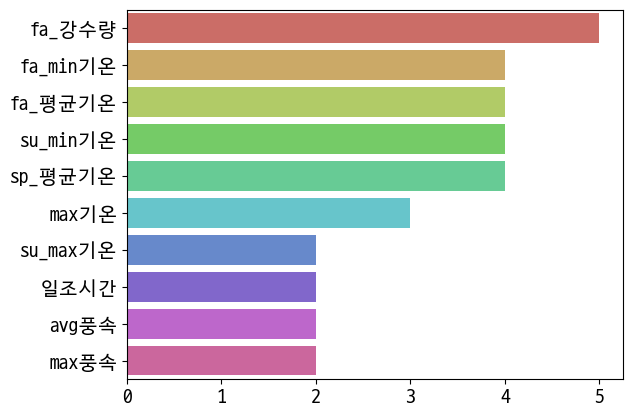

In [53]:
fi_value = best_lgbm_model.feature_importances_
fi = pd.Series(fi_value, X.columns)
fi_top10 = fi.sort_values(ascending=False)[:10]

sns.barplot(x=fi_top10.values, y=fi_top10.index, palette='hls')

# 피처 중요도 시각화

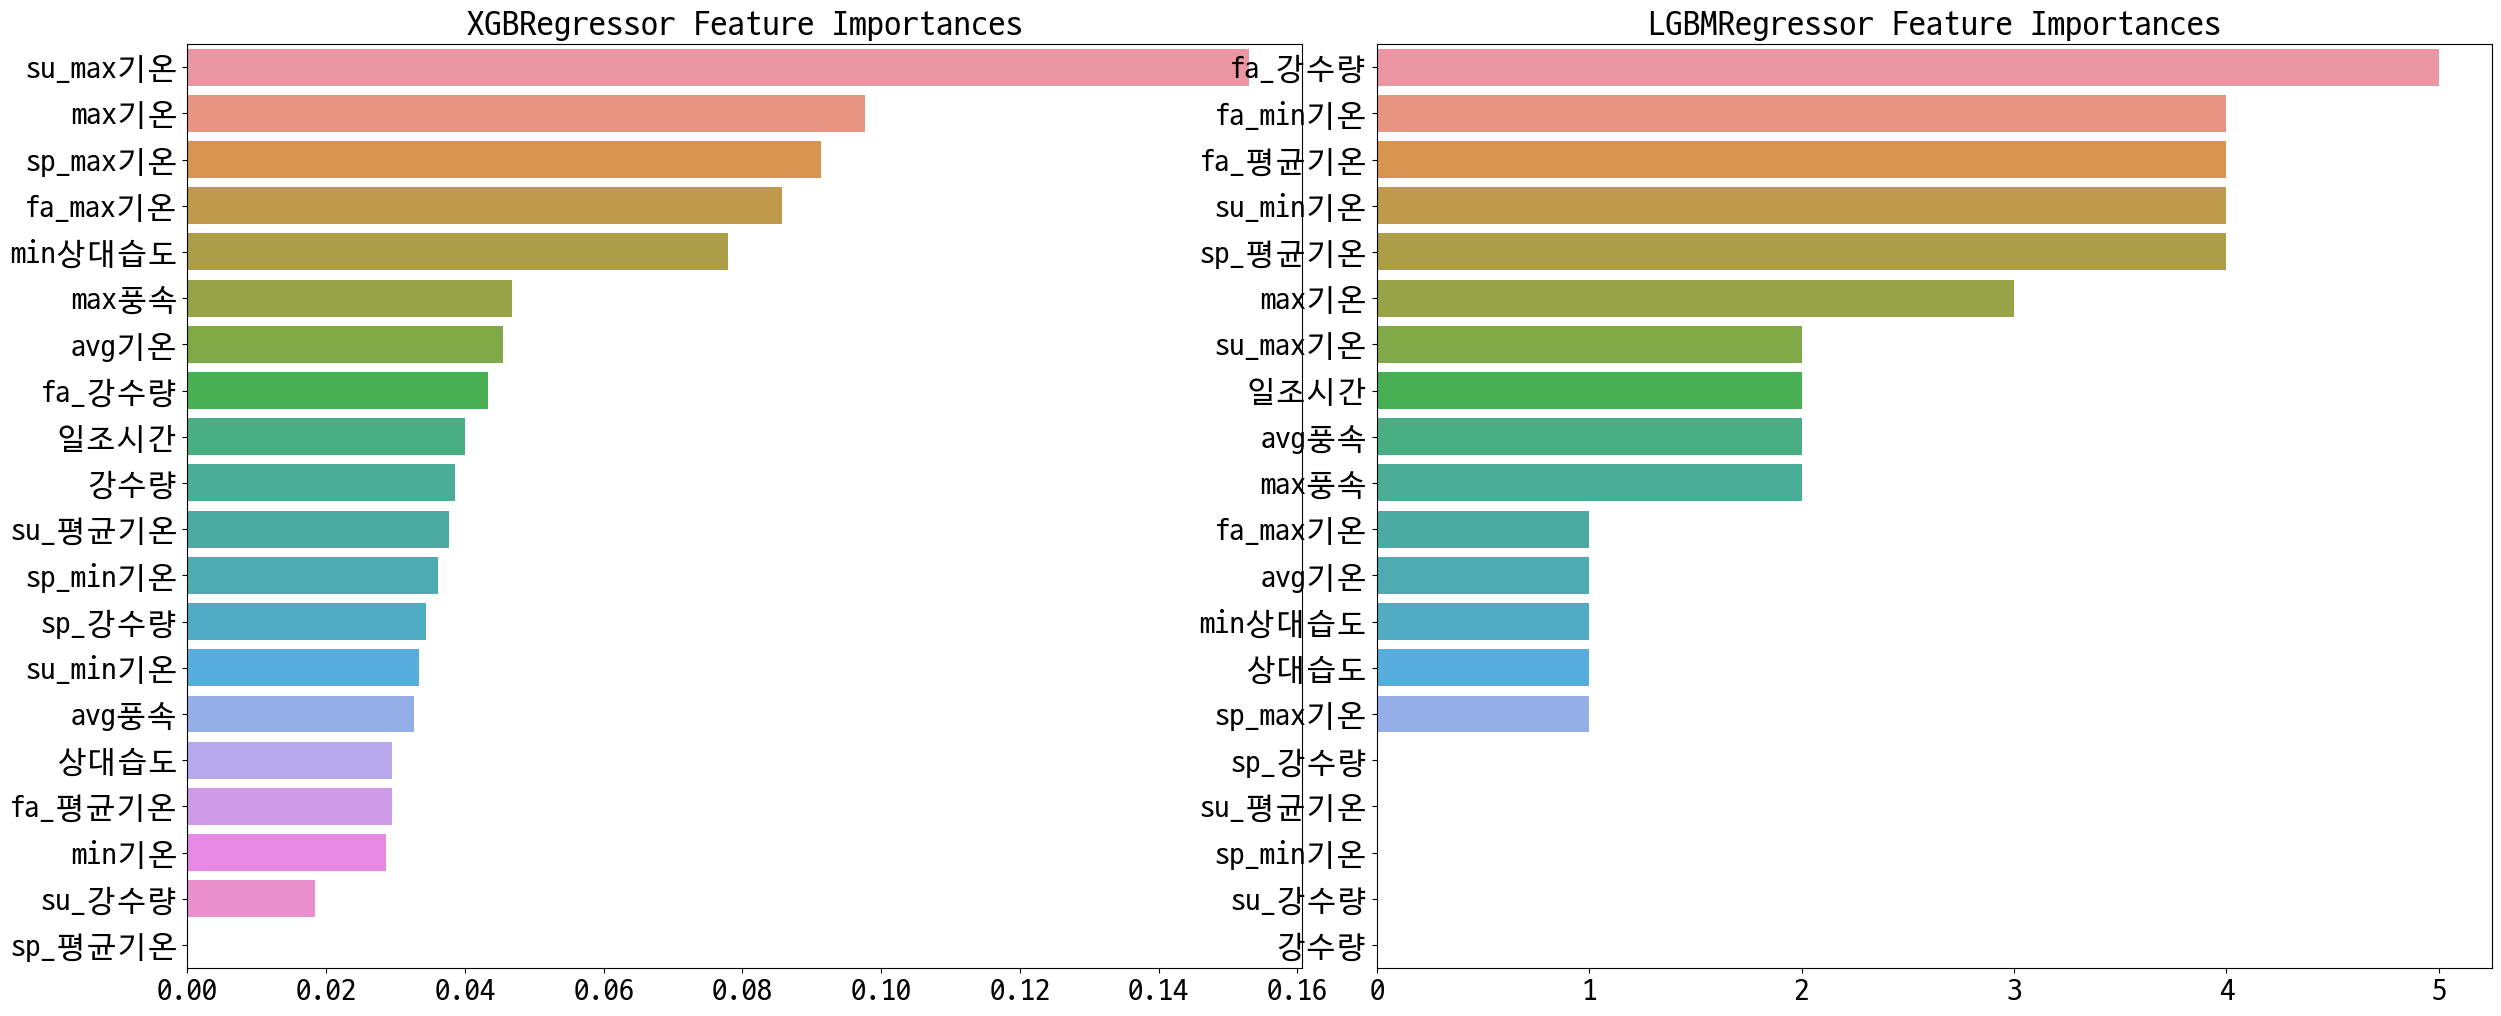

In [54]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb_model, best_lgbm_model]
visualize_ftr_importances(models)

# 예측결과 혼합

In [55]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE:{1}'.format(key,rmse))

In [56]:
xgb_pred = best_xgb_model.predict(X_test)
lgbm_pred = best_lgbm_model.predict(X_test)

In [57]:
pred = 0.2 * xgb_pred + 0.8 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE:0.17809018695577492
XGBM 모델의 RMSE:0.1843641162583066
LGBM 모델의 RMSE:0.17869721268234728


In [58]:
result = pd.concat([pd.DataFrame(np.expm1(lgbm_pred)), np.expm1(y_test).reset_index(drop=True)], axis=1)

In [59]:
result['error'] = result.iloc[:,0] - result.iloc[:,1]

In [60]:
result

,0,단위생산량,error
0,1748.046889,1657.0,91.046889
1,1805.049451,2957.1,-1152.050549
2,1500.361147,1235.6,264.761147
3,1900.057633,1483.3,416.757633
4,1916.160495,2274.6,-358.439505
5,1860.282834,2051.5,-191.217166
6,1866.771472,2022.6,-155.828528
7,2021.177631,1938.9,82.277631
8,1795.372240,1848.0,-52.627760
9,1694.068186,1206.8,487.268186


# Gradient Boost Regression 향후 예측

## 강원도 예측

In [61]:
X_test = pd.read_csv('data/gangwonchange.csv', encoding='cp949')

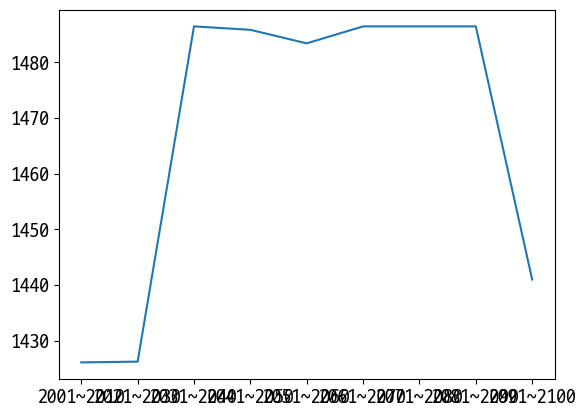

In [62]:
year = X_test['년']
X_test.drop(columns='년', inplace=True)

xgb_pred = best_xgb_model.predict(X_test)
lgbm_pred = best_lgbm_model.predict(X_test)

pred = 0.2 * xgb_pred + 0.8 * lgbm_pred

predict = pd.DataFrame(np.expm1(pred))
predict['년'] = year
predict.columns = ['예상', '년']

plt.plot(predict['년'], predict['예상'])

In [63]:
predict.to_csv('data/predict/gangwon_gbr.csv', encoding='cp949', index=False)

## 충남 예측

In [64]:
X_test = pd.read_csv('data/chungnamchange.csv', encoding='cp949')

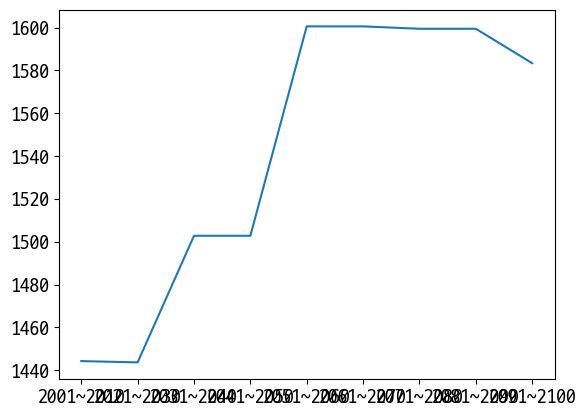

In [65]:
year = X_test['년']
X_test.drop(columns='년', inplace=True)

xgb_pred = best_xgb_model.predict(X_test)
lgbm_pred = best_lgbm_model.predict(X_test)

pred = 0.2 * xgb_pred + 0.8 * lgbm_pred

predict = pd.DataFrame(np.expm1(pred))
predict['년'] = year
predict.columns = ['예상', '년']

plt.plot(predict['년'], predict['예상'])

In [66]:
predict.to_csv('data/predict/chungnam_gbr.csv', encoding='cp949', index=False)

## 경북 예측

In [67]:
X_test = pd.read_csv('data/gyeongbukchange.csv', encoding='cp949')

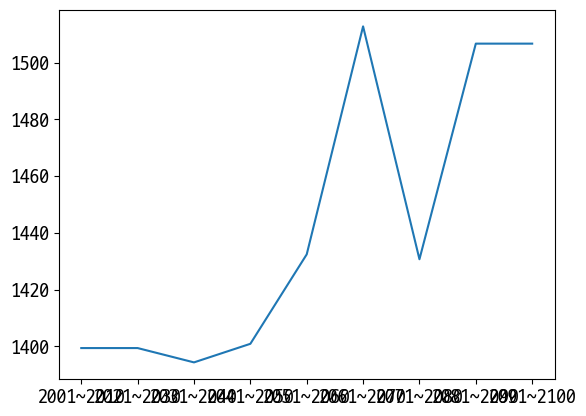

In [68]:
year = X_test['년']
X_test.drop(columns='년', inplace=True)

xgb_pred = best_xgb_model.predict(X_test)
lgbm_pred = best_lgbm_model.predict(X_test)

pred = 0.2 * xgb_pred + 0.8 * lgbm_pred

predict = pd.DataFrame(np.expm1(pred))
predict['년'] = year
predict.columns = ['예상', '년']

plt.plot(predict['년'], predict['예상'])

In [69]:
predict.to_csv('data/predict/gyeongbuk_gbr.csv', encoding='cp949', index=False)